In [1]:
import os

# You can use 'tensorflow', 'torch' or 'jax' as backend. Make sure to set the environment variable before importing.
os.environ["KERAS_BACKEND"] = "tensorflow"

import mlflow
import numpy as np
import tensorflow as tf
import keras_core
from PIL import Image
import keras.backend as K
import keras
import matplotlib.pyplot as plt
import torch
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist


# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

mlflow.set_tracking_uri(uri="http://localhost:5000")
mlflow.autolog()


2024-03-04 09:46:10.370430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 09:46:10.370466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 09:46:10.371479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 09:46:10.377179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 09:46:10.944258: W tensorflow/compiler/tf2

Using TensorFlow backend


2024/03/04 09:46:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [2]:
assert tf.__version__.startswith('2.')
# Set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


2024-03-04 09:46:14.377650: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 09:46:14.378572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 09:46:14.378776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
def initialize_model():
    INPUT_SHAPE = (100, 100, 1)  # Assuming grayscale images of 100x100 pixels
    model = keras_core.Sequential(
        [
            keras_core.layers.Input(shape=INPUT_SHAPE),
            keras_core.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            keras_core.layers.MaxPooling2D((2, 2)),
            # Add more Conv2D or MaxPooling2D layers as needed
            keras_core.layers.Flatten(),
            keras_core.layers.Dense(64, activation='relu'),
            keras_core.layers.Dense(6)  
        ]
    )
    return model

model = initialize_model()
model.summary()
# keras_core.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 76832)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 64)                │  4,917,312 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 6)                 │        390 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 4,918,022 (18.76 MB)

 Trainable params: 4,918,022 (18.76 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def load_image(image_path, size=(100, 100)):
    with Image.open(image_path) as img:
        img = img.convert('L')  # Convert to grayscale
        img = img.resize(size)  # Resize image
        return np.array(img)

def load_dataset(dataset_path, labels, size=(100, 100)):
    num_samples = len(labels)
    # Assuming images are grayscale, adjust the shape accordingly
    # For RGB images, use size + (3,)
    images = np.zeros((num_samples, size[0], size[1]), dtype=np.float32)
    vertices = np.zeros((num_samples, 6), dtype=np.float32)  # Adjust size based on label structure

    for idx, label in enumerate(labels):
        img_path = os.path.join(dataset_path, label['file_name'])
        images[idx] = load_image(img_path, size=size) / 255.0  # Normalize images
        vertices[idx] = np.array(label['vertices']).flatten()

    return images, vertices


In [9]:
dataset_path = '/home/jay/AI/data/triangles_dataset/'
labels = np.load(os.path.join(dataset_path, 'labels.npy'), allow_pickle=True)

images, vertices = load_dataset(dataset_path, labels)


In [4]:
# def custom_loss(y_true, y_pred):
#     # Assuming the vertices are stored as (x1, y1, x2, y2, x3, y3)
#     true_vertices = K.reshape(y_true, (-1, 3, 2))
#     pred_vertices = K.reshape(y_pred, (-1, 3, 2))

#     # Calculate the true and predicted centers
#     true_center = K.mean(true_vertices, axis=1)
#     pred_center = K.mean(pred_vertices, axis=1)

#     # Calculate the distance between the true vertices and the predicted center
#     center_distances = K.sqrt(K.sum(K.square(true_vertices - pred_center[:, None, :]), axis=-1))

#     # The loss is the mean squared error of the vertices plus a penalty term for the center distances
#     C=4
#     vertex_loss = K.mean(K.square(y_true - y_pred), axis=-1)
#     center_penalty = K.mean(center_distances, axis=-1)*C

#     return vertex_loss + center_penalty

@keras_core.saving.register_keras_serializable()
def loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

In [5]:
model.compile(
    optimizer='adam',
    loss=loss, 
)

In [ ]:

model.fit(
    x=images,
    y=vertices,
    batch_size=3,
    epochs=15,
    validation_split=0.1  # You can use validation split directly with NumPy arrays
)

In [11]:
def plot_vertices(image, real_vertices, predicted_vertices, calculate_distances):
    """
    Plot the image, real vertices, predicted vertices, and lines between predicted vertices and their closest real vertices.
    Annotate the lines with the calculated distances and display the sum of distances.

    Parameters:
    image (torch.Tensor or np.ndarray): The image tensor or numpy array.
    real_vertices (np.ndarray): Real vertices as a numpy array.
    predicted_vertices (np.ndarray): Predicted vertices as a numpy array.
    calculate_distances (function): Function to calculate distances and closest indices.
    """
    # Ensure real and predicted vertices are in the correct shape
    real_vertices = real_vertices.reshape((-1, 2))
    predicted_vertices = predicted_vertices.reshape((-1, 2))

    # Convert the image tensor to a numpy array for plotting
    if isinstance(image, torch.Tensor):
        image_np = image.detach().cpu().numpy().squeeze()  # Adjusted for potential tensor characteristics
    elif isinstance(image, np.ndarray):
        image_np = image
    else:
        raise TypeError("Image must be a torch.Tensor or np.ndarray.")
    
    # Calculate distances and closest indices using the provided function
    min_distances, closest_indices = calculate_distances(predicted_vertices, real_vertices)
    
    # Calculate the sum of the distances
    sum_of_distances = np.sum(min_distances)
    
    # Create the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image_np, cmap='gray')
    plt.scatter(real_vertices[:, 0], real_vertices[:, 1], color='green', label='Real Vertices')
    plt.scatter(predicted_vertices[:, 0], predicted_vertices[:, 1], color='red', label='Predicted Vertices')
    
    # Draw lines and annotate distances
    for i, (dist, closest_idx) in enumerate(zip(min_distances, closest_indices)):
        pred_vertex = predicted_vertices[i]
        closest_real_vertex = real_vertices[closest_idx]
        plt.plot([pred_vertex[0], closest_real_vertex[0]], [pred_vertex[1], closest_real_vertex[1]], 'b--')
        mid_point = (pred_vertex + closest_real_vertex) / 2
        plt.text(mid_point[0], mid_point[1], f'{dist:.2f}', color='blue')
    
    # Display the sum of distances
    plt.title(f'Sum of Distances: {sum_of_distances:.2f}')
    plt.legend()
    plt.show()


def calculate_distances(predicted_vertices, real_vertices):

    """
    Calculate the distance from each predicted vertex to the nearest real vertex,
    ensuring that no two predicted vertices are paired with the same real vertex.

    Parameters:
    predicted_vertices (np.ndarray): 2D array of predicted vertices [N, 2].
    real_vertices (np.ndarray): 2D array of real vertices [M, 2].

    Returns:
    tuple: A tuple containing:
        - distances (np.ndarray): The distances of predicted vertices to their assigned real vertex.
        - assignment_indices (np.ndarray): The indices of the real vertices assigned to each predicted vertex.
    """
    # Calculate all pairwise distances
    distances = cdist(predicted_vertices, real_vertices)
    
    # Solve the assignment problem
    predicted_indices, real_indices = linear_sum_assignment(distances)
    
    # Calculate the minimum distances based on the optimal assignment
    min_distances = distances[predicted_indices, real_indices]
    
    return min_distances, real_indices




In [ ]:
model.save('modelo_MSE.keras')

In [15]:
model = tf.keras.models.load_model('modelo_MSE.keras', custom_objects={'loss': loss})

/home/jay/.local/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:731: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


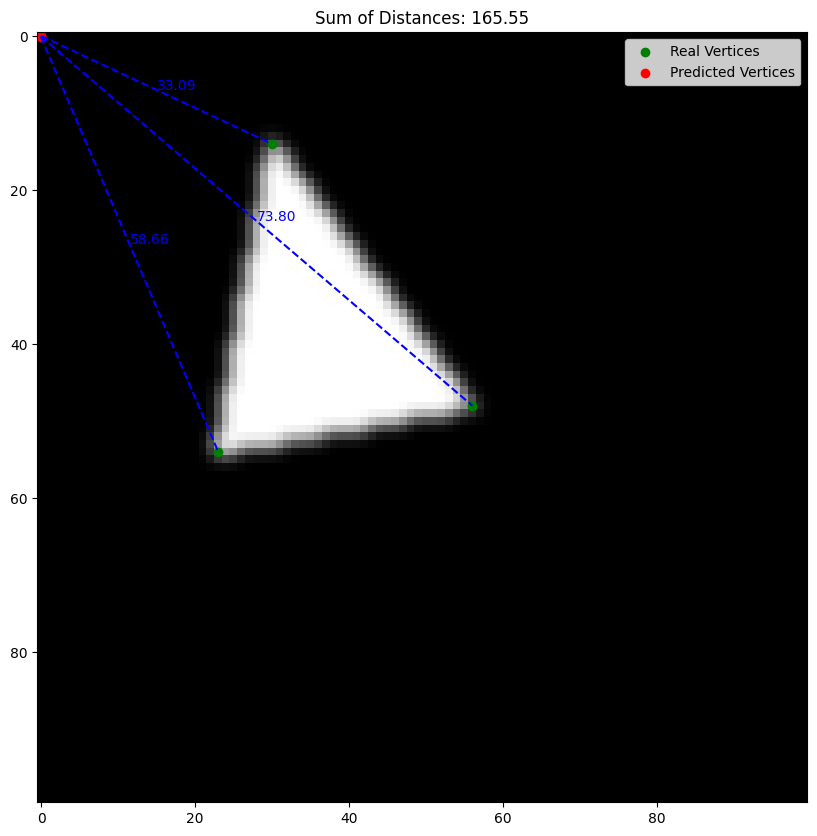

In [17]:
random_index = np.random.randint(0, len(images))
plot_vertices(images[random_index], vertices[random_index], model.predict(images[random_index][None, ...]), calculate_distances)

21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


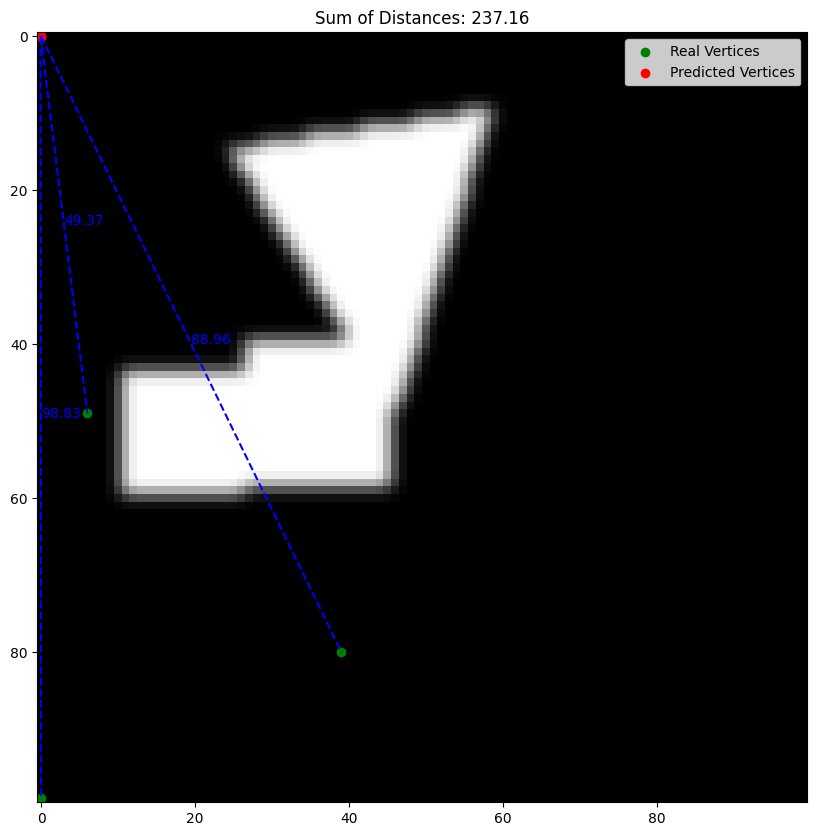

In [18]:
dataset_test_path = '/home/jay/AI/data/triangles_test/'
labels_test = np.load(os.path.join(dataset_test_path, 'labels.npy'), allow_pickle=True)

images_test, vertices_test = load_dataset(dataset_test_path, labels_test)

random_index = np.random.randint(0, len(images_test))
print(random_index)
plot_vertices(images_test[random_index], vertices_test[random_index], model.predict(images_test[random_index][None, ...]), calculate_distances)